In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from brokenaxes import brokenaxes
from boxsers.preprocessing import rubberband_baseline_cor

mpl.rcParams['font.size'] = 8

2024-09-10 01:30:53.564140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 01:30:53.577446: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 01:30:53.581265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from scipy.signal import savgol_filter, find_peaks

In [4]:
def pseudo_voigt(x, mu, gamma_gaussian, gamma_lorentzian, amplitude, eta):
    """ 
    Voigt profile approximation by linear combination of
    Lorenzian and Gaussian distributinos.
    mu, A, A0, FWHM, eta
    """
    a_G = (2 / gamma_gaussian) * np.sqrt(np.log(2) / np.pi)
    b_G = (4 * np.log(2)) / (gamma_gaussian**2)
    gaussian_term = a_G * np.exp(-b_G * (x - mu)**2)
    
    lorentzian_term = (1 / np.pi) * ( (gamma_lorentzian / 2) / ( (x - mu)**2 + (gamma_lorentzian / 2)**2) ) 
    
    result = amplitude * (eta * gaussian_term + (1 - eta) * lorentzian_term)

    return result

In [5]:
x_values = np.linspace(0, 100, 1000)
y_values = (
            np.exp(-(x_values - 20)**2 / (2 * 5**2)) +
            np.exp(-(x_values - 25)**2 / (2 * 2**2)) +
            np.exp(-(x_values - 30)**2 / (2 * 2**2)) +
            np.exp(-(x_values - 50)**2 / (2 * 5**2)) +
            np.exp(-(x_values - 75)**2 / (2 * 3**2)) +
            np.exp(-(x_values - 80)**2 / (2 * 2**2)) + 
            np.random.normal(0, 0.001, x_values.size)
            )

In [7]:
df = pd.read_csv("~/data/dataset_681.csv")
wn = pd.read_csv("~/data/dataset_565_domain.csv").to_numpy().reshape(-1)
X = df.drop(columns=['HbA1c', 'Age'])
X.columns = wn


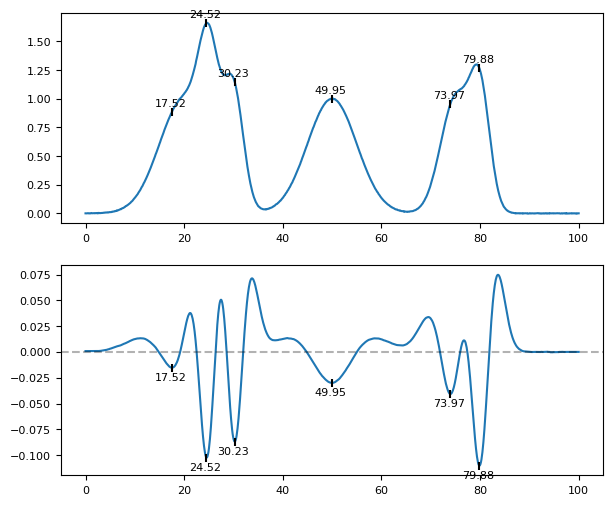

,Index,Value
0,175,17
1,245,24
2,302,30
3,499,49
4,739,73
5,798,79


In [8]:
def peaks_second_deriv(x_values, 
                       y_values, 
                       window_length=10,
                       polyorder=2,
                       **kwargs):
    
    first_deriv = savgol_filter(y_values, window_length=window_length, polyorder=polyorder, deriv=1)
    second_deriv = savgol_filter(y_values, window_length=window_length, polyorder=polyorder, deriv=2)
    second_deriv = second_deriv / np.linalg.norm(second_deriv)
    peaks = find_peaks(-second_deriv, **kwargs)[0]

    fig, axs = plt.subplots(2, 1, figsize=(7, 6))
    axs[0].plot(x_values, y_values)
    axs[0].scatter(x_values[peaks], y_values[peaks], color='k', marker='|', linewidth=1.5, zorder=5)

    for peak in peaks:
        peak_pos = x_values[peak]
        axs[0].annotate(f'{peak_pos:.2f}', 
                        xy=(peak_pos, y_values[peak]), 
                        xytext=(peak_pos - 3.5, y_values[peak] + 0.1 * y_values.mean()),
                        fontsize=8
                        )

    axs[1].plot(x_values, second_deriv)
    axs[1].scatter(x_values[peaks], second_deriv[peaks], color='k', marker='|', linewidth=1.5, zorder=5)
    axs[1].axhline(y=0, linestyle="--", alpha=0.3, color='k')

    for peak in peaks:
        peak_pos = x_values[peak]
        axs[1].annotate(f'{peak_pos:.2f}', 
                        xy=(peak_pos, second_deriv[peak]), 
                        xytext=(peak_pos - 3.5, second_deriv[peak] - 0.6 * np.abs(second_deriv).mean()),
                        fontsize=8
                        )
        
    peak_results = pd.DataFrame({
        "Index": peaks,
        "Value": [int(x_values[peak]) for peak in peaks]
    })

    plt.show()

    return peak_results

peaks_second_deriv(x_values, 
                   y_values, 
                   window_length=50, 
                   height=0.001, 
                   prominence=0.0001, 
                   distance=20)

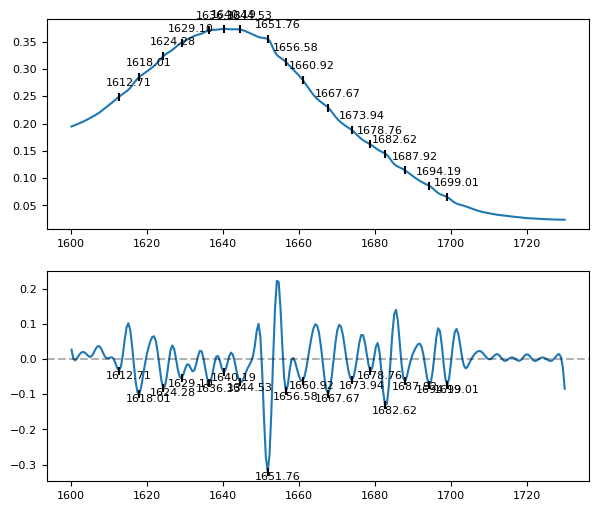

In [9]:
sample = X.mean()
sample = sample[(sample.index >= 1600) & (sample.index <= 1730)]

res = peaks_second_deriv(sample.index.to_numpy(), 
                   sample.to_numpy(), 
                   window_length=21,
                   polyorder=7,
                   height=0.03, 
                   prominence=0.00001, 
                   distance=7)

In [10]:
# res['Value'].to_csv("~/data/peaks_amide1.csv", index=None)

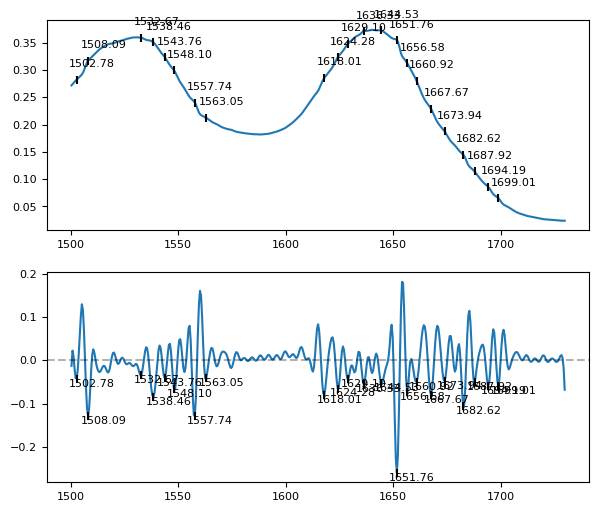

In [11]:
sample = X.mean()
sample = sample[(sample.index >= 1500) & (sample.index <= 1730)]

res_1500_1700 = peaks_second_deriv(sample.index.to_numpy(), 
                   sample.to_numpy(), 
                   window_length=21,
                   polyorder=7,
                   height=0.03, 
                   prominence=0.00001, 
                   distance=7)

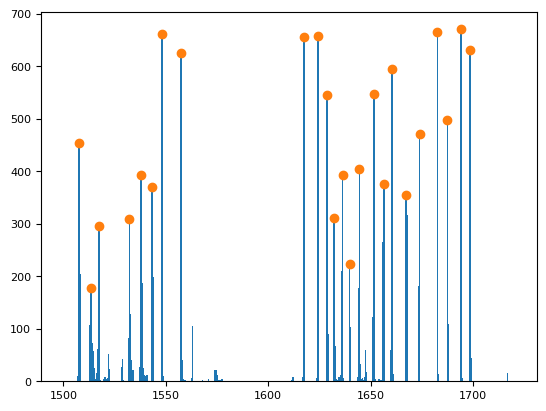

In [12]:
def find_peaks_matrix(domain,
                      absorbance,
                      window_length=10,
                      polyorder=2,
                      threshold=0.5,
                      **kwargs):
    
    n_samples, n_features = absorbance.shape
    
    X_deriv = absorbance.T.apply(lambda col: savgol_filter(col, 
                                                           window_length=window_length, 
                                                           polyorder=polyorder, 
                                                           deriv=2)).T
    X_deriv = X_deriv.apply(lambda row: row / np.linalg.norm(row), axis=1)

    total_peaks = np.zeros(n_features)


    for index, row in X_deriv.iterrows():
        peaks = find_peaks(-row, **kwargs)[0]
        total_peaks[peaks] += 1


    peaks_counts, *_ = find_peaks(total_peaks, height=int(n_samples * threshold))
    plt.bar(domain, total_peaks)
    plt.scatter(domain[peaks_counts], total_peaks[peaks_counts])
    # plt.xlim([1600, 1730])
    plt.show()

    # print(peaks_counts.shape)
    # absorbance.T.plot(legend=False)
    # plt.scatter(domain[peaks_counts], absorbance.mean().to_numpy()[peaks_counts])

    return domain[peaks_counts]

X_amide1 = X.iloc[:, (X.columns >= 1500) & (X.columns <= 1720)]

peaks_amides = find_peaks_matrix(X_amide1.columns.to_numpy(), 
                   X_amide1, 
                   window_length=10, 
                   height=0.03, 
                   prominence=0.0001, 
                   distance=7,
                   threshold=0.2)

<Axes: >

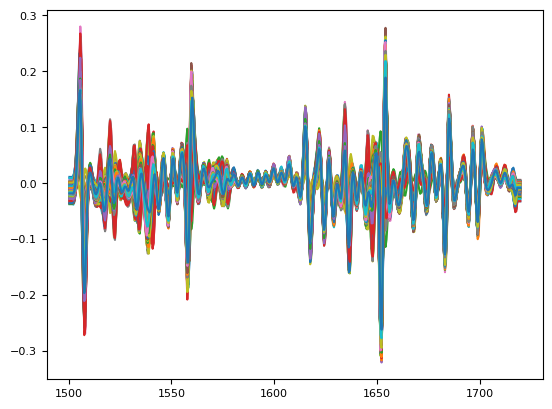

In [13]:
X_deriv = X_amide1.T.apply(lambda col: savgol_filter(col, window_length=7, polyorder=2, deriv=2)).T
X_deriv = X_deriv.apply(lambda row: row / np.linalg.norm(row), axis=1)
X_deriv.T.plot(legend=False)

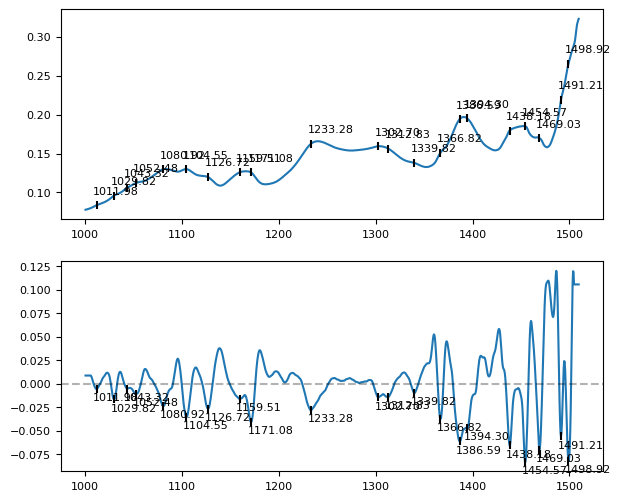

In [14]:
sample = X.mean()
sample = sample[(sample.index >= 1000) & (sample.index <= 1510)]

res_1000_1500 = peaks_second_deriv(sample.index.to_numpy(), 
                   sample.to_numpy(), 
                   window_length=20, 
                   polyorder=2,
                   height=0.005, 
                   prominence=0.00001, 
                   distance=15)

In [15]:
res_1000_1500

,Index,Value
0,24,1011
1,61,1029
2,89,1043
3,108,1052
4,167,1080
5,216,1104
6,262,1126
7,330,1159
8,354,1171
9,483,1233


In [16]:
res_1500_1700

,Index,Value
0,5,1502
1,16,1508
2,67,1532
3,79,1538
4,90,1543
5,99,1548
6,119,1557
7,130,1563
8,244,1618
9,257,1624


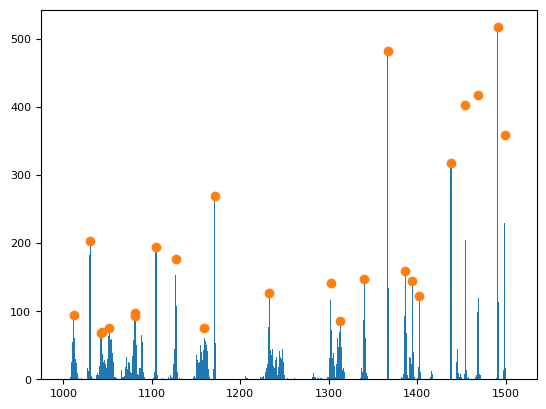

In [22]:
X_1000_1500 = X.iloc[:, (X.columns >= 1000) & (X.columns <= 1510)]

peaks_1000_1500 = find_peaks_matrix(X_1000_1500.columns.to_numpy(), 
                X_1000_1500, 
                window_length=20,
                polyorder=2,
                height=0.004, 
                prominence=0.00001, 
                distance=10,
                threshold=0.1
                )

<Axes: >

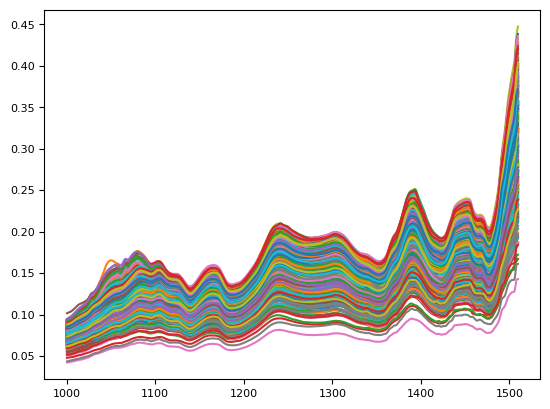

In [23]:
X_1000_1500.T.plot(legend=False)

In [29]:
len(peaks_amides)

24

In [30]:
len(peaks_1000_1500)

24

In [34]:
peaks_all = np.concatenate([peaks_1000_1500, peaks_amides])

In [35]:
def filter_points_by_distance(points, min_distance):
    """
    Filters points from a sorted array that are closer together than a specified minimum distance.
    
    Parameters:
        points (numpy.ndarray): A sorted array of points.
        min_distance (float): The minimum allowed distance between consecutive points.

    Returns:
        numpy.ndarray: A filtered array of points.
    """
    if len(points) == 0:
        return points 

    filtered_points = [points[0]]
    
    for i in range(1, len(points)):
        if points[i] - filtered_points[-1] >= min_distance:
            filtered_points.append(points[i])
    
    return np.array(filtered_points)

In [36]:
import plotly.graph_objs as go

x_values = X.columns.to_numpy()
y_values = X.mean().to_numpy()

peaks = np.concatenate([peaks_1000_1500, peaks_amides])
peaks = filter_points_by_distance(peaks, 3)

peaks_idx = [np.argmin(np.abs(x_values - peak)) for peak in peaks]
print("length: ", len(peaks))


# plt.plot(x_values, y_values)
# plt.scatter(x_values[peaks_idx], y_values[peaks_idx])
# plt.xlim([1000, 1720])


fig = go.Figure()

fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='lines', name='Signal'))
fig.add_trace(go.Scatter(x=[x_values[i] for i in peaks_idx], y=[y_values[i] for i in peaks_idx], 
                         mode='markers', name='Peaks', marker=dict(color='red', size=10)))
fig.update_xaxes(range=[1000, 1720])

fig.update_layout(
    width=1000, 
    height=600
)
fig.show()

pd.Series(peaks).to_csv(f'~/data/peaks_{int(len(peaks))}.csv', index=False)
peaks

length:  46


array([1011.497, 1030.3  , 1042.353, 1051.996, 1080.441, 1104.547,
       1127.207, 1159.028, 1171.563, 1232.793, 1302.701, 1313.307,
       1340.306, 1366.823, 1386.59 , 1394.786, 1402.5  , 1438.178,
       1454.088, 1469.034, 1491.211, 1499.408, 1507.604, 1513.389,
       1517.246, 1532.192, 1537.978, 1543.281, 1548.102, 1557.262,
       1617.528, 1624.278, 1628.617, 1631.992, 1636.331, 1639.706,
       1644.527, 1651.759, 1656.58 , 1660.437, 1667.187, 1673.937,
       1682.615, 1687.436, 1694.186, 1698.525])

In [37]:
# wavenumber_mask = ((X.columns >= 1000) & (X.columns <= 3700)) & ~((X.columns > 1800) & (X.columns < 2700))
# X = X.iloc[:, wavenumber_mask]
# X.head(10)

In [ ]:
# fig = plt.figure(figsize=(8, 2))
# bax = brokenaxes(xlims=((1000, 1800), (2700, 3700)))

# wn = X.columns
# absorbance = X.mean()

# bax.plot(wn, absorbance)
# # bax.legend(loc=3)
# bax.set_xlabel('Wavenumber')
# bax.set_ylabel('Absorbance')

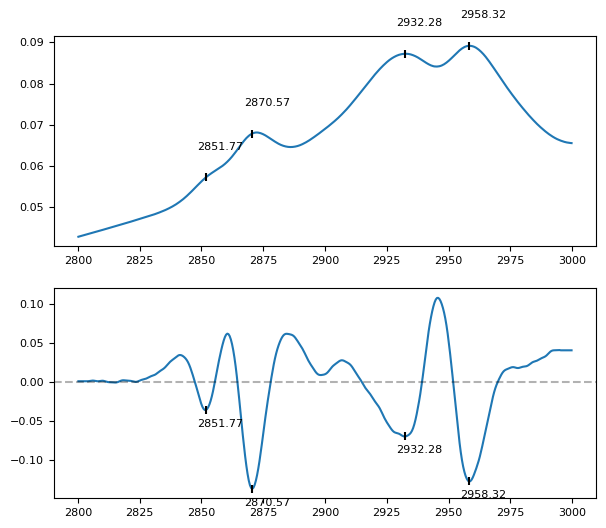

,Index,Value
0,107,2851
1,146,2870
2,274,2932
3,328,2958


In [ ]:
sample = X.mean()
sample = sample[(sample.index >= 2800) & (sample.index <= 3000)]

peaks_second_deriv(sample.index.to_numpy(), 
                   sample.to_numpy(), 
                   window_length=18, 
                   polyorder=2,
                   height=0.001, 
                   prominence=0.00001, 
                   distance=10)

In [ ]:
# pd.Series(np.concatenate([res_1000_1500['Value'], res_1500_1700['Value']])).to_csv("~/data/peaks_42_m.csv", index=None)